## Krichmar Path Planning using Nengo - Tutorial

This tutorial covers the following:
- Delay Nodes used to represent difficulty of traversal for each map location
- Hints on how to implement inhibition (turn neurons off once a map location has fired)
- How to build your AER

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

from nengo.processes import Piecewise
from nengo.processes import WhiteSignal


### Delays using Nengo Nodes

We can use a Nengo node to implement an n-timestep delayed connection by using a node. Why might you want a delay? Recall our bubblesort outputs. They were not precise as we had expected because of some of the feedback delays due to calculations. We may want to send something in at the exact same time to prevent this (or explore dynamics to adjust for the delays - both options have pros/cons!). Ultimately, you may want to wait to send an input into a neuron for a variety of reasons and this code will help you make that happen.

This example uses object-oriented programming to set up the delay. You can find a pretty good tutorial on the topic [here](https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html). You can also see how `np.roll` works [here](https://numpy.org/doc/stable/reference/generated/numpy.roll.html).

The class `Delay` starts off with an array called `self.history` of 250 zeros (each time step is `dt=.001` seconds and we want a `time_delay=25` seconds, which is in total 250 time steps). For the first actual time step of the system ($t=1$), the `self.history` array updates to $\begin{bmatrix} 0 & 0 & ... & x(1) \end{bmatrix}$, but what leaves the node is the first element of the array, 0. This is what we want! We are delaying our signal while storing what will come 250 timesteps later. At the next time step ($t=2$), the `self.history` array updates to $\begin{bmatrix} 0 & 0 & ... & x(1) & x(2) \end{bmatrix}$. Keep going until time step $t=250$ and you should get the `self.history` array $\begin{bmatrix} x(1) & x(2) & ... & x(249) & x(250) \end{bmatrix}$ and the first element $x(1)$ is what leaves the node. That means at time step 250, you're just now seeing the start of the original signal, i.e. you've delayed the signal by 250 timesteps!



In [5]:
model = nengo.Network(label="Delayed connection")
with model:
    # We'll use white noise as input
    inp = nengo.Node(WhiteSignal(2, high=5), size_out=1)
    A = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(inp, A)


# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]

dt = 0.001 # default nengo timestep
time_delay = .25 # seconds by which you wish to delay the signal
delay = Delay(1, timesteps=int(time_delay / dt))

with model:
    delaynode = nengo.Node(delay.step, size_in=1, size_out=1)
    nengo.Connection(A, delaynode)

    # Send the delayed output through an ensemble
    B = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(delaynode, B)

    # Probe the input at the delayed output
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:02.                                                 


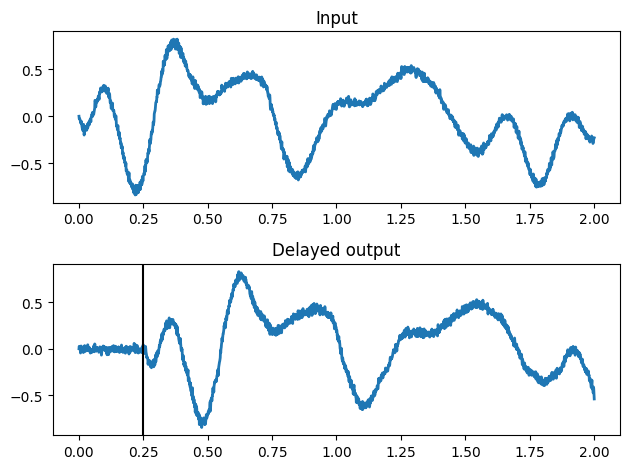

In [6]:
# Run for 2 seconds
with nengo.Simulator(model) as sim:
    sim.run(2)

# Plot the results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[A_probe], lw=2)
plt.title("Input")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[B_probe], lw=2)
plt.axvline(time_delay, c="k")
plt.title("Delayed output")
plt.tight_layout()


#### Discussion

The delay nodes should be placed _prior_ to the map locations they are delaying. Think through this and decide for yourself whether or not that makes sense. 

If you aren't convinced, consider the delay the difficulty of traversal. Example: a map location has a weight / difficulty of 3 which means it'll take 3 seconds to get through said map location. If you place the delay just prior to the map location neuron, the map location will begin firing at the same(ish) time as the delay node. This occurs 3 seconds _after_ it receives a spike from it's neighbor. The output spike will then go to the delay nodes of it's neighbors, which have delays of whatever the neighbor's weights are. Rinse. Repeat.

### Inhibition using Nengo Nodes

Who's to say we cannot use something similar to that delay in order to inhibit our maps once they've fired once?? At this point from what we've tried (myself and other instructors), I think inhibiting with a node function will be your best bet. You can include the function within the _same_ delay node (or not - your call).

Some thoughts:
- Once a map location begins spiking, it fires for a brief pulse, then stops firing
- This means you first have a drastic increase (`started_spiking = True`). Prior, this was `False`
- Once `started_spiking = True`, you should have a drastic decrease soon after (`finished_spiking = True`)
- Once `finished_spiking = True`, you can just return 0 forever after (instead of `self.history[0]` - assuming you bundle the function within the same node)!

In [7]:
# Give this a try on your own or in groups first. If you're lost, send a message on Teams!

### Inhibition using Nengo Neurons

We (myself and other instructors) have made a lot of progress on this one, but it's not quite perfect and ready to be used yet. We will spend some time during one of the next few lectures covering this one to show how to work through the complexities of Nengo, since that's certaintly coming for you in just a few short weeks as our Final Projects begin. 

I also think having a way to inhibit neurons is critical to many algorithm implementations - which means I suspect at least one of you will need to know how to do this for your Final Project.

### Building your AER

Creating a table of map locations and time of first spike isn't as scary as it may seem at first glance. You know how to probe neurons, and you know how to plot the probed data. That means that at every time step of your simulation, your neuron outputs have a value. When said value hits that first rapid increase, you can find at what time this happens within the simulation by analyzing the amplitude and store that time for a particular map location. Let's look at an example.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


Text(0.5, 1.0, 'Neuron Output')

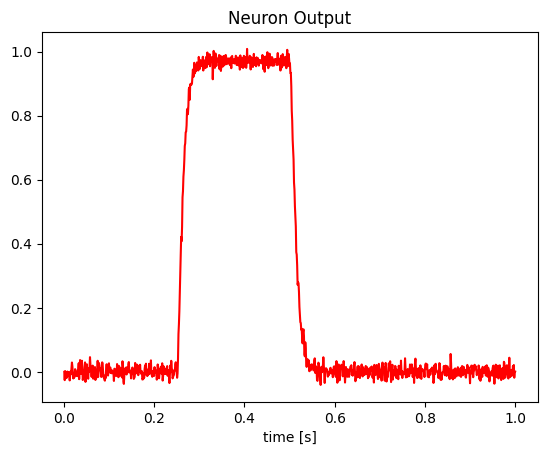

In [13]:
model = nengo.Network(label="AER")
with model:

    inp_node = nengo.Node(Piecewise({0: 0, .25: 1, .5: 0})) # quick spike into start node

    inp_neuron = nengo.Ensemble(100, 1)

    nengo.Connection(inp_node,inp_neuron)

    neuron_probe = nengo.Probe(inp_neuron, synapse=0.01)

# Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(1)

# Plot the decoded input from the neuron
plt.figure()
plt.plot(sim.trange(), sim.data[neuron_probe], "r")
plt.xlabel("time [s]")
plt.title("Neuron Output")


From here, let's figure out where the first spike occurs using `sim.data[neuron_probe]` (should be around .25 seconds).

_All of this happens OFF-NEURON_, i.e. we don't build the map or find our optimal path within our Nengo model. We do this in regular Python-land.

In [18]:
# note that sim.data[neuron_probe] is an Nx1 array, 
#  which means there's a second dimension we don't care about.
#  The spike data occurs in dimension 0. Grab that one.
aer = sim.data[neuron_probe][:,0]>.25
spikes_locs = np.where(aer == True)
first_spike = np.min(spikes_locs)

print("This is time step where the pulse first begins: ", first_spike)

dt = .001 # default nengo timestep
print("This time step occurs at approximately ", first_spike*dt, " seconds")

This is time step where the pulse first begins:  257
This time step occurs at approximately  0.257  seconds


#### Discussion

Build your AER table for every neuron in your map. Then _using your map_, work backwards as we discussed in class to find your optimal path!

**You now should have everything you need to implement Path Planning! Due date is 3/18 for everyone - keep working hard, send questions on Teams, and request EI for Monday if you need it!**